# Part 1, Topic 1: Introduction to Clock Glitching (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Microcontrollers and FPGAs have a number of operating conditions that must be met in order for the device to work properly. Outside of these conditions, devices will begin to malfunction, with more extreme violations causing the device to stop entirely or even become damaged. By going outside these operating conditions for very small amounts of time, we can cause a varitey of temporary malfunctions*

*In this lab, we'll explore clock glitching, which inserts short glitches into a device's clock. This will be used to get a target that's summing numbers in a loop to arrive at the wrong result.*

**LEARNING OUTCOMES:**

* Understand effects of clock glitching
* Exploring ChipWhisperer's glitch module
* Using clock glitching to disrupt a target's algorithm

## Clock Glitching Theory

Digital hardware devices almost always expect some form of reliable clock. We can manipulate the clock being presented to the device to cause unintended behaviour. We'll be concentrating on microcontrollers here, however other digital devices (e.g. hardware encryption accelerators) can also have faults injected using this technique.

Consider a microcontroller first. The following figure is an excerpt from the Atmel AVR ATMega328P datasheet:

![A2_1](img/Mcu-unglitched.png)

Rather than loading each instruction from FLASH and performing the entire execution, the system has a pipeline to speed up the execution process. This means that an instruction is being decoded while the next one is being retrieved, as the following diagram shows:

![A2_2](img/Clock-normal.png)

But if we modify the clock, we could have a situation where the system doesn't have enough time to actually perform an instruction. Consider the following, where Execute #1 is effectively skipped. Before the system has time to actually execute it another clock edge comes, causing the microcontroller to start execution of the next instruction:

![A2_3](img/Clock-glitched.png)

This causes the microcontroller to skip an instruction. Such attacks can be immensely powerful in practice. Consider for example the following code from `linux-util-2.24`:

```C
/*
 *   auth.c -- PAM authorization code, common between chsh and chfn
 *   (c) 2012 by Cody Maloney <cmaloney@theoreticalchaos.com>
 *
 *   this program is free software.  you can redistribute it and
 *   modify it under the terms of the gnu general public license.
 *   there is no warranty.
 *
 */

#include "auth.h"
#include "pamfail.h"

int auth_pam(const char *service_name, uid_t uid, const char *username)
{
    if (uid != 0) {
        pam_handle_t *pamh = NULL;
        struct pam_conv conv = { misc_conv, NULL };
        int retcode;

        retcode = pam_start(service_name, username, &conv, &pamh);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_authenticate(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_acct_mgmt(pamh, 0);
        if (retcode == PAM_NEW_AUTHTOK_REQD)
            retcode =
                pam_chauthtok(pamh, PAM_CHANGE_EXPIRED_AUTHTOK);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        retcode = pam_setcred(pamh, 0);
        if (pam_fail_check(pamh, retcode))
            return FALSE;

        pam_end(pamh, 0);
        /* no need to establish a session; this isn't a
         * session-oriented activity...  */
    }
    return TRUE;
}
```

This is the login code for the Linux OS. Note that if we could skip the check of `if (uid != 0)` and simply branch to the end, we could avoid having to enter a password. This is the power of glitch attacks - not that we are breaking encryption, but simply bypassing the entire authentication module! 

### Glitch Hardware

The ChipWhisperer Glitch system uses the same synchronous methodology as its Side Channel Analysis (SCA) capture. A system clock (which can come from either the ChipWhisperer or the Device Under Test (DUT)) is used to generate the glitches. These glitches are then inserted back into the clock, although it's possible to use the glitches alone for other purposes (i.e. for voltage glitching, EM glitching).

The generation of glitches is done with two variable phase shift modules, configured as follows:

![A2_4](img/Glitchgen-phaseshift.png)

The enable line is used to determine when glitches are inserted. Glitches can be inserted continuously (useful for development) or triggered by some event. The following figure shows how the glitch can be muxd to output to the Device Under Test (DUT).

![A2_5](img/Glitchgen-mux.png)

### Hardware Support

The phase shift blocks use the Digital Clock Manager (DCM) blocks within the FPGA. These blocks have limited support for run-time configuration of parameters such as phase delay and frequency generation, and for maximum performance the configuration must be fixed at design time. The Xilinx-provided run-time adjustment can shift the phase only by about +/- 5nS in 30pS increments (exact values vary with operating conditions).

For most operating conditions this is insufficient - if attacking a target at 7.37MHz the clock cycle would have a period of 136nS. In order to provide a larger adjustment range, an advanced FPGA feature called Partial Reconfiguration (PR) is used. The PR system requires special partial bitstreams which contain modifications to the FPGA bitstream. These are stored as two files inside a "firmware" zip which contains both the FPGA bitstream along with a file called `glitchwidth.p` and a file called `glitchoffset.p`. If a lone bitstream is being loaded into the FPGA (i.e. not from the zip-file), the partial reconfiguration system is disabled, as loading incorrect partial reconfiguration files could damage the FPGA. This damage is mostly theoretical, more likely the FPGA will fail to function correctly.

If in the course of following this tutorial you find the FPGA appears to stop responding (i.e. certain features no longer work correctly), it could be the partial reconfiguration data is incorrect.

We'll look at how to interface with these features later in the tutorial.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
SS_VER = 'SS_VER_1_1'

In [2]:
import chipwhisperer as cw

scope = cw.scope()
if SS_VER == 'SS_VER_1_1':
    target_type = cw.targets.SimpleSerial
target = cw.target(scope, target_type)
if PLATFORM == 'CWLITEXMEGA':
    prog = cw.programmers.XMEGAProgrammer

In [3]:
import time
time.sleep(0.05)
scope.default_setup()
def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.1)
        scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
        time.sleep(0.1) #xmega needs more startup time
    else:  
        scope.io.nrst = 'low'
        time.sleep(0.05)
        scope.io.nrst = 'high_z'
        time.sleep(0.05)

In [4]:
%%bash -s "$PLATFORM" "$SS_VER"
cd ../../../hardware/victims/firmware/simpleserial-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$2

SS_VER set to SS_VER_1_1
rm -f -- simpleserial-glitch-CWLITEXMEGA.hex
rm -f -- simpleserial-glitch-CWLITEXMEGA.eep
rm -f -- simpleserial-glitch-CWLITEXMEGA.cof
rm -f -- simpleserial-glitch-CWLITEXMEGA.elf
rm -f -- simpleserial-glitch-CWLITEXMEGA.map
rm -f -- simpleserial-glitch-CWLITEXMEGA.sym
rm -f -- simpleserial-glitch-CWLITEXMEGA.lss
rm -f -- objdir-CWLITEXMEGA/*.o
rm -f -- objdir-CWLITEXMEGA/*.lst
rm -f -- simpleserial-glitch.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-glitch.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-glitch.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
Welcome to another exciting ChipWhisperer target build!!
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: s

In [5]:
fw_path = "../../../hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(PLATFORM)
cw.program_target(scope, prog, fw_path)

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 2559 bytes


We'll probably crash the target a few times while we're trying some glitching. Create a function to reset the target:

In [6]:
if PLATFORM == "CWLITEXMEGA":
    def reboot_flush():            
        scope.io.pdic = False
        time.sleep(0.1)
        scope.io.pdic = "high_z"
        time.sleep(0.1)
        #Flush garbage too
        target.flush()
else:
    def reboot_flush():            
        scope.io.nrst = False
        time.sleep(0.05)
        scope.io.nrst = "high_z"
        time.sleep(0.05)
        #Flush garbage too
        target.flush()

## Communication

For this lab, we'll be introducing a new method: `target.simpleserial_read_witherrors()`. We're expecting a simpleserial response back; however, glitch will often cause the target to crash and return an invalid string. This method will handle all that for us. It'll also tell us whether the response was valid and what the error return code was. Use as follows:

In [7]:
import struct
#Do glitch loop
target.simpleserial_write("g", bytearray([]))

val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
valid = val['valid']
if valid:
    response = val['payload']
    raw_serial = val['full_response']
    error_code = val['rv']

#print(bytearray(val['full_response'].encode('latin-1')))
gcnt = struct.unpack("<I", val['payload'])[0]
print(val)
print(gcnt)

{'valid': True, 'payload': CWbytearray(b'c4 09 00 00'), 'full_response': 'rC4090000\n', 'rv': 0}
2500


## Target Firmware

For this lab, our goal is to get the following code to preduce an incorrect result:

```C
uint8_t glitch_loop(uint8_t* in)
{
    volatile uint16_t i, j;
    volatile uint32_t cnt;
    cnt = 0;
    trigger_high();
    for(i=0; i<50; i++){
        for(j=0; j<50; j++){
            cnt++;
        }
    }
    trigger_low();
    simpleserial_put('r', 4, (uint8_t*)&cnt);
    return (cnt != 2500);
}
```

As you can see, we've got a simple loop. This is a really good place to start glitching for 2 reasons:

1. We've got a really long portion of time with a lot of instructions to glitch. In contrast, with the Linux example we're be trying to target a single instruction.

1. For some glitching scenarios, we're looking for a pretty specific glitch effect. In the Linux example, we might be banking on the glitch causing the target to skip an instruction instead of corrupting the comparison since that's a lot more likely to get us where we want in the code path. For this simple loop calculation, pretty much any malfunction will show up in the result.

## Glitch Module

All the settings/methods for the glitch module can be accessed under `scope.glitch`. As usual, documentation for the settings and methods can be accessed on [ReadtheDocs](https://chipwhisperer.readthedocs.io/en/latest/api.html) or with the python `help` command:

In [8]:
help(scope.glitch)

Help on GlitchSettings in module chipwhisperer.capture.scopes.cwhardware.ChipWhispererGlitch object:

class GlitchSettings(chipwhisperer.common.utils.util.DisableNewAttr)
 |  GlitchSettings(cwglitch)
 |  
 |  Provides an ability to disable setting new attributes in a class, useful to prevent typos.
 |  
 |  Usage:
 |  1. Make a class that inherits this class:
 |  >>> class MyClass(DisableNewAttr):
 |  >>>     # Your class definition here
 |  
 |  2. After setting up all attributes that your object needs, call disable_newattr():
 |  >>>     def __init__(self):
 |  >>>         self.my_attr = 123
 |  >>>         self.disable_newattr()
 |  
 |  3. Subclasses raise an AttributeError when trying to make a new attribute:
 |  >>> obj = MyClass()
 |  >>> #obj.my_new_attr = 456   <-- Raises AttributeError
 |  
 |  Method resolution order:
 |      GlitchSettings
 |      chipwhisperer.common.utils.util.DisableNewAttr
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cw

In [9]:
scope.glitch

clk_src     = target
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = manual
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor

Some of the important settings we'll want to look at here are:

* clk_src
> The clock signal that the glitch DCM is using as input. Can be set to "target" or "clkgen" In this case, we'll be providing the clock to the target, so we'll want this set to "clkgen"
* offset
> Where in the output clock to place the glitch. Can be in the range `[-50, 50]`. Often, we'll want to try many offsets when trying to glitch a target.
* width
> How wide to make the glitch. Can be in the range `[-50, 50]`, though there is no reason to use widths < 0. Wider glitches more easily cause glitches, but are also more likely to crash the target, meaning we'll often want to try a range of widths when attacking a target.
* output
> The output produced by the glitch module. For clock glitching, clock_xor is often the most useful option.
* ext_offset
> The number of clock cycles after the trigger to put the glitch. 
* repeat
> The number of clock cycles to repeat the glitch for. Higher values increase the number of instructions that can be glitched, but often increase the risk of crashing the target.
* trigger_src
> How to trigger the glitch. For this tutorial, we want to automatically trigger the glitch from the trigger pin only after arming the ChipWhipserer, so we'll use `ext_single`

In addition, we'll need to tell ChipWhipserer to use the glitch module's output as a clock source for the target by setting `scope.io.hs2 = "glitch"`. We'll also setup a large `repeat` to make glitching easier. Finally, we'll also use a `namedtuple` to make looping through parameters simpler.

## CW Glitch Controller

To make creating a glitch loop easier, ChipWhisperer includes a glitch controller. We'll start of by initializing with different potential results of the attack. You define these to be whatever you want, but typically "success", "reset", and "normal" will be sufficient. We also need to tell it what glitch parameters we want to scan through, in this case width and offset:

In [10]:
import chipwhisperer.common.results.glitch as glitch
gc = glitch.GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])

One of the niceties of the glitch controller is that it can display our current settings. This will update in real time as we use the glitch controller!

In [11]:
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

We can also make a settings map that can also update in realtime as well:

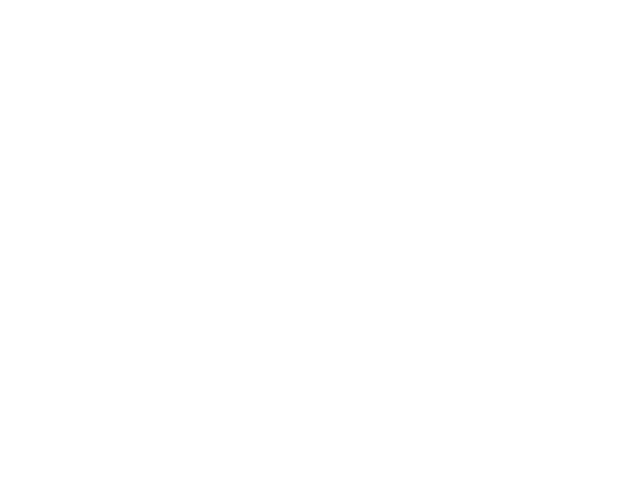

In [12]:
%matplotlib ipympl
import matplotlib.pylab as plt
fig = plt.figure()

In [13]:
## to update the plot:
plt.plot(-5, 5, '.')
fig.canvas.draw()

You can set ranges for each glitch setting:

In [14]:
gc.set_range("width", -5, 5)
gc.set_range("offset", -5, 5)

Each setting moves from min to max based on the global step:

In [15]:
gc.set_global_step([5.0, 2.5])

We can print out all the glitch settings to see how this looks:

In [16]:
for glitch_setting in gc.glitch_values():
    print('-------------------------------------')
    print("Offset: {}".format(glitch_setting[1]))
    print("Width: {}".format(glitch_setting[0]))
    print('-------------------------------------')

-------------------------------------
Offset: -5
Width: -5
-------------------------------------
-------------------------------------
Offset: 0.0
Width: -5
-------------------------------------
-------------------------------------
Offset: 5.0
Width: -5
-------------------------------------
-------------------------------------
Offset: -5
Width: 0.0
-------------------------------------
-------------------------------------
Offset: 0.0
Width: 0.0
-------------------------------------
-------------------------------------
Offset: 5.0
Width: 0.0
-------------------------------------
-------------------------------------
Offset: -5
Width: 5.0
-------------------------------------
-------------------------------------
Offset: 0.0
Width: 5.0
-------------------------------------
-------------------------------------
Offset: 5.0
Width: 5.0
-------------------------------------
-------------------------------------
Offset: -5
Width: -5
-------------------------------------
------------------

You can tell the glitch controller when you've reached a particular result state like so:

In [17]:
#gc.add("reset", (scope.glitch.width, scope.glitch.offset))
#gc.add("success", (scope.glitch.width, scope.glitch.offset))

We'll start off with the following settings. It's usually best to use "clock_xor" with clock glitching, which will insert a glitch if the clock is high or the clock is low.

In [18]:
#Basic setup
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "clock_xor" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

scope.io.hs2 = "glitch"  # output glitch_out on the clock line
print(scope.glitch)

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor



Should have all you need to construct your glitch loop. We'll get you started, but the rest is up to you! Also, some stuff to keep in mind:

* You'll need to detect crashes, successful glitches, and normal returns from the target. Don't be afraid to experiment with the loop: you can always restart it and rerun the code.
* You can cover a larger set of glitch settings by starting with large glitch controller steps to get idea where some interesting locations are, then repeating the glitch loop with small steps in interesting areas. Where there's one successful glitch, there's probably more!
* You can speed up your glitch campaign substantially by only plotting crashes and successes, since they're typically much rarer than normal behaviour in the target

In [19]:
gc.display_stats()

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=-5.0, continuous_update=False, description='width setting:', disabled=True, max=5.0, min=-5.…

FloatSlider(value=-5.0, continuous_update=False, description='offset setting:', disabled=True, max=5.0, min=-5…

In [21]:
import chipwhisperer.common.results.glitch as glitch
import struct

scope.glitch.ext_offset = 2

gc.set_range("width", 0, 15)
gc.set_range("offset", -15, 5)
gc.set_global_step([1])
scope.glitch.repeat = 10

scope.adc.timeout = 0.1

reboot_flush()

for glitch_setting in gc.glitch_values():
    
    # optional: you can speed up the loop by checking if the trigger never went low
    #           (the target never called trigger_low();) via scope.adc.state
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]

    if scope.adc.state:
        # can detect crash here (fast) before timing out (slow)
        print("Trigger still high!")
        gc.add("reset", (scope.glitch.width, scope.glitch.offset))
        plt.plot(lwid, loff, 'xr', alpha=1)
        fig.canvas.draw()

        #Device is slow to boot?
        reboot_flush()

    scope.arm()
    
    target.simpleserial_write("g", bytearray([]))
    
    ret = scope.capture()
    
    val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)#For loop check
    loff = scope.glitch.offset
    lwid = scope.glitch.width
    # ###################
    # Add your code here
    # ###################
    
    if ret: #here the trigger never went high - sometimes the target is still crashed from a previous glitch
        print('Timeout - no trigger')
        gc.add("reset", (scope.glitch.width, scope.glitch.offset))
        plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
        fig.canvas.draw()

        #Device is slow to boot?
        reboot_flush()
    else:
        if val['valid'] is False:
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            plt.plot(scope.glitch.width, scope.glitch.offset, 'xr', alpha=1)
            fig.canvas.draw()
        else:
            if val['payload'] is None:
                print("None! payload: {}".format(val['payload']))
                continue
            gcnt = struct.unpack("<I", val['payload'])[0]
            
            if gcnt == 2500: #normal response
                gc.add("normal", (scope.glitch.width, scope.glitch.offset))
            else: #glitch!!!
                # print(val['payload'][0])
                gc.add("success", (scope.glitch.width, scope.glitch.offset))
                
print("Done Glitching !")

Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Trigger still high!
Trigger still high!
Trigger still high!
Trigger still high!


Done Glitching !


### Plotting Glitch Results

One thing you can do to speed up your glitch acquisition is avoid plotting glitch results while you're trying to glitch the target. That being said, it's still often helpful to plot this data at some point to get a visual reference for good glitch spots. ChipWhisperer has built in functionality for plotting the results of a glitch campagin. Simply call the the following:

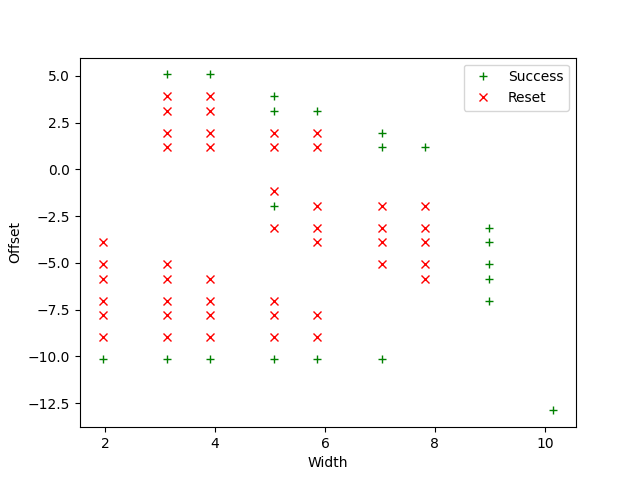

In [22]:
%matplotlib ipympl
gc.results.plot_2d(plotdots={"success":"+g", "reset":"xr", "normal":None})

Make sure you write down those glitch settings, since we'll be using for the rest of the glitching labs! In fact, we'll be using a lot of the general code structure here for the rest of the labs, with the only big changes being:

### Repeat

This lab used a pretty large repeat value. Like the name suggests, this setting controls how many times the glitch is repeated (i.e. a repeat value of 5 will place glitches in 5 consecutive clock cycles). Consider that each glitch inserted has a chance to both cause a glitch or crash the device. This was pretty advantageous for this lab since we had a lot of different spots we wanted to place a glitch - using a high repeat value increased our chance for a crash, but also increased our chance for a successful glitch. For an attack where we're targeting a single instruction, we don't really increase our glitch chance at all, but still have the increased crash risk. Worse yet, a successful glitch in a wrong spot may also cause a crash! It is for that reason that it's often better to use a low repeat value when targeting a single instruction.

### Ext Offset

The ext offset setting controls a delay between the trigger firing and the glitch being inserted. Like repeat, it's based on whole clock cycles, meaning an ext offset of 10 will insert a glitch 10 cycles after the trigger fires. We didn't have to worry about this setting for this lab since the large repeat value was able to take us into the area we wanted. This won't be true for many applications, where you'll have to try glitches at a large variety of ext_offsets.

### Success, Reset, and Normal

These three result states are usually enough to describe most glitch results. What constitues a success, however, will change based on what firmware you're attacking. For example, if we were attacking the Linux authentication, we might base success on a check to see whether or not we're root.

In [23]:
target.dis()
scope.dis()

True